In [15]:
using CSV, DataFrames, CairoMakie, NonlinearSolve, QuadGK, ForwardDiff

In [16]:
Λ = 0.65
Nf = 2
Nc = 3
G = (9/2)*2.0 / Λ^2 # ???

# Δ is actually |Δ|
Epm(Δ, μ, λ, k, s) = 1/2 * (s*sqrt((k - λ - μ)^2 + 8Nf*Δ^2) + k + λ - μ)
E(μ, k) = k - μ
σ(Δ, μ, λ, k) = sqrt((k - λ - μ)^2 + 8Nf*Δ^2)

θ(x) = x > 0 ? 1 : 0
f0(Δ, μ, λ, k) = θ(-k - λ + μ - σ(Δ, μ, λ,k))*Epm(Δ, μ, λ, k, 1) + θ(-k - λ + μ + σ(Δ, μ, λ,k))*Epm(Δ, μ, λ, k, -1) + θ(μ - k)*E(μ, k)
#I'm not sure if forwarddiff will catch those theta functions
df0dλ(Δ, μ, λ, k) = ForwardDiff.derivative(λi -> f0(Δ, μ, λi, k), λ)

function Ω(Δ, μ, λ)
    I1 = quadgk(k -> k^2*df0dλ(Δ, μ, λ, k), 0, Λ)[1]
    I2 = quadgk(k -> k^2*f0(Δ, μ, λ, k), 0, Λ)[1]

    s = 1
    # if λ < 0
    #     s = -1
    # end

    -λ*s*Nc/π^2 * I1 + Nc/π^2 * I2 + 8Nf/G * Δ^2
end

function gap(Δ, μ, λ)
    I2(Δi) = quadgk(k -> k^2*f0(Δi, μ, λ, k), 0, Λ)[1]

    Nc/π^2 * ForwardDiff.derivative(Δi -> I2(Δi), Δ) + 16Nf/G * Δ
end

# gap(Δ, μ, λ) = ForwardDiff.derivative(Δi -> Ω(Δi, μ, λ), Δ)

function solvegap(μ, λ)
    xmin1 = -0.005
    xmax1 = 0.005
    xmin2 = 0.005
    xmax2 = 0.03

    f(x, param) = gap(x[1], μ, λ)

    xguess = [(xmin1, xmax1), (xmin2, xmax2)]
    if (gap(xmin2, μ, λ) * gap(xmax2, μ, λ) > 0)
        xguess = [(xmin1, xmax1)]
    end

    sols = zeros(size(xguess))
    Threads.@threads for i in eachindex(sols)
        prob = IntervalNonlinearProblem(f, xguess[i], ())
        sol = solve(prob, maxiters=1000, abstol=1e-8)
        sols[i] = sol.u
    end

    Ωsols = [Ω(sol, μ, λ) for sol in sols]
    return sols[findmin(Ωsols)[2]]
end

solvegap (generic function with 1 method)

In [24]:
μi = 0.5
λi = -0.02
Δsol = solvegap(μi, λi)
println(Δsol)

0.016297972588084658


In [23]:
ngrid1 = 10
ngrid2 = 10

μvals = range(0.3, 0.5, length=ngrid1)
λvals = range(-0.015, 0.015, length=ngrid2)
Δsols = zeros(ngrid1, ngrid2)

Threads.@threads for i in 1:ngrid1
    Threads.@threads for j in 1:ngrid2
        Δsols[i, j] = solvegap(μvals[i], λvals[j])
    end
end

CompositeException: TaskFailedException

    nested task error: TaskFailedException
    
        nested task error: InterruptException:
        Stacktrace:
          [1] *(x::Float64, y::ForwardDiff.Dual{ForwardDiff.Tag{var"#76#77"{Float64, Float64, Float64}, Float64}, Float64, 1})
            @ ForwardDiff ~/.julia/packages/ForwardDiff/UBbGT/src/dual.jl:149
          [2] Epm(Δ::Float64, μ::Float64, λ::ForwardDiff.Dual{ForwardDiff.Tag{var"#76#77"{Float64, Float64, Float64}, Float64}, Float64, 1}, k::Float64, s::Int64)
            @ Main ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:7
          [3] f0(Δ::Float64, μ::Float64, λ::ForwardDiff.Dual{ForwardDiff.Tag{var"#76#77"{Float64, Float64, Float64}, Float64}, Float64, 1}, k::Float64)
            @ Main ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:12
          [4] #76
            @ ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:14 [inlined]
          [5] derivative
            @ ~/.julia/packages/ForwardDiff/UBbGT/src/derivative.jl:14 [inlined]
          [6] df0dλ(Δ::Float64, μ::Float64, λ::Float64, k::Float64)
            @ Main ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:14
          [7] (::var"#78#80"{Float64, Float64, Float64})(k::Float64)
            @ Main ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:17
          [8] evalrule(f::var"#78#80"{Float64, Float64, Float64}, a::Float64, b::Float64, x::Vector{Float64}, w::Vector{Float64}, wg::Vector{Float64}, nrm::typeof(LinearAlgebra.norm))
            @ QuadGK ~/.julia/packages/QuadGK/BjmU0/src/evalrule.jl:32
          [9] refine(f::var"#78#80"{Float64, Float64, Float64}, segs::Vector{QuadGK.Segment{Float64, Float64, Float64}}, I::Float64, E::Float64, numevals::Int64, x::Vector{Float64}, w::Vector{Float64}, wg::Vector{Float64}, n::Int64, atol::Float64, rtol::Float64, maxevals::Int64, nrm::typeof(LinearAlgebra.norm))
            @ QuadGK ~/.julia/packages/QuadGK/BjmU0/src/adapt.jl:115
         [10] adapt(f::var"#78#80"{Float64, Float64, Float64}, segs::Vector{QuadGK.Segment{Float64, Float64, Float64}}, I::Float64, E::Float64, numevals::Int64, x::Vector{Float64}, w::Vector{Float64}, wg::Vector{Float64}, n::Int64, atol::Float64, rtol::Float64, maxevals::Int64, nrm::typeof(LinearAlgebra.norm))
            @ QuadGK ~/.julia/packages/QuadGK/BjmU0/src/adapt.jl:96
         [11] do_quadgk(f::var"#78#80"{Float64, Float64, Float64}, s::Tuple{Float64, Float64}, n::Int64, atol::Nothing, rtol::Nothing, maxevals::Int64, nrm::typeof(LinearAlgebra.norm), _segbuf::Nothing, eval_segbuf::Nothing)
            @ QuadGK ~/.julia/packages/QuadGK/BjmU0/src/adapt.jl:87
         [12] (::QuadGK.var"#50#51"{Nothing, Nothing, Int64, Int64, typeof(LinearAlgebra.norm), Nothing, Nothing})(f::Function, s::Tuple{Float64, Float64}, ::Function)
            @ QuadGK ~/.julia/packages/QuadGK/BjmU0/src/api.jl:83
         [13] handle_infinities
            @ ~/.julia/packages/QuadGK/BjmU0/src/adapt.jl:189 [inlined]
         [14] #quadgk#49
            @ ~/.julia/packages/QuadGK/BjmU0/src/api.jl:82 [inlined]
         [15] quadgk
            @ ~/.julia/packages/QuadGK/BjmU0/src/api.jl:80 [inlined]
         [16] quadgk(::Function, ::Int64, ::Float64)
            @ QuadGK ~/.julia/packages/QuadGK/BjmU0/src/api.jl:77
         [17] Ω(Δ::Float64, μ::Float64, λ::Float64)
            @ Main ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:17
         [18] #88
            @ ./none:0 [inlined]
         [19] iterate
            @ ./generator.jl:48 [inlined]
         [20] collect(itr::Base.Generator{Vector{Float64}, var"#88#92"{Float64, Float64}})
            @ Base ./array.jl:780
         [21] solvegap(μ::Float64, λ::Float64)
            @ Main ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W1sZmlsZQ==.jl:56
         [22] macro expansion
            @ ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:10 [inlined]
         [23] (::var"#187#threadsfor_fun#97"{var"#187#threadsfor_fun#94#98"{Int64, UnitRange{Int64}}})(tid::Int64; onethread::Bool)
            @ Main ./threadingconstructs.jl:252
         [24] #187#threadsfor_fun
            @ ./threadingconstructs.jl:219 [inlined]
         [25] (::Base.Threads.var"#1#2"{var"#187#threadsfor_fun#97"{var"#187#threadsfor_fun#94#98"{Int64, UnitRange{Int64}}}, Int64})()
            @ Base.Threads ./threadingconstructs.jl:154
    Stacktrace:
     [1] threading_run(fun::var"#187#threadsfor_fun#97"{var"#187#threadsfor_fun#94#98"{Int64, UnitRange{Int64}}}, static::Bool)
       @ Base.Threads ./threadingconstructs.jl:172
     [2] macro expansion
       @ ./threadingconstructs.jl:189 [inlined]
     [3] macro expansion
       @ ~/src/kondoeff/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sZmlsZQ==.jl:9 [inlined]
     [4] (::var"#173#threadsfor_fun#95"{var"#173#threadsfor_fun#93#96"{UnitRange{Int64}}})(tid::Int64; onethread::Bool)
       @ Main ./threadingconstructs.jl:252
     [5] #173#threadsfor_fun
       @ ./threadingconstructs.jl:219 [inlined]
     [6] (::Base.Threads.var"#1#2"{var"#173#threadsfor_fun#95"{var"#173#threadsfor_fun#93#96"{UnitRange{Int64}}}, Int64})()
       @ Base.Threads ./threadingconstructs.jl:154

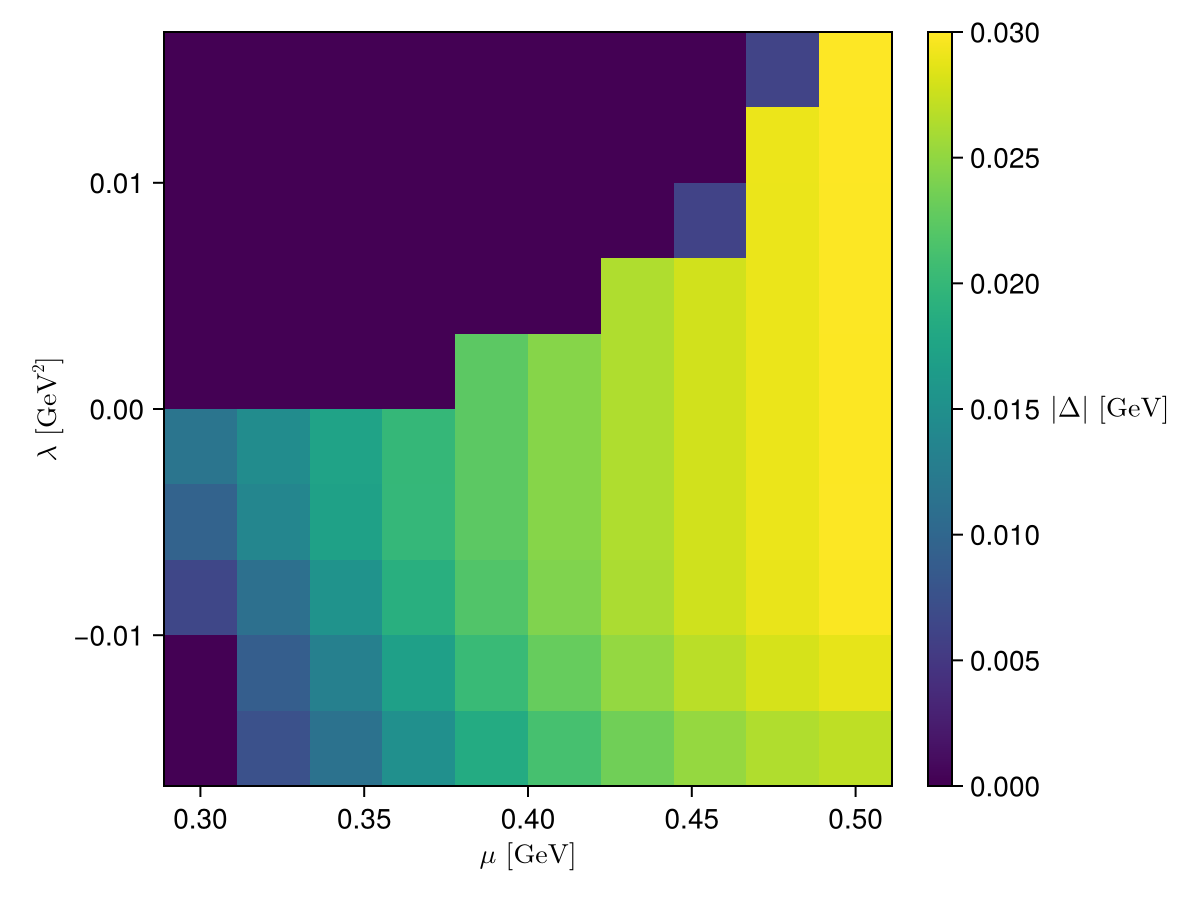

In [68]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = L"$\mu$ [GeV]",
    ylabel = L"$\lambda$ [GeV$^2$]"
)

heatmap!(ax, μvals, λvals, Δsols)

Colorbar(fig[1,2], limits=(0, 0.030), label=L"$|\Delta|$ [GeV]", labelrotation=0)
save("gapheatmap.png", fig)
fig